In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/MNIST/NonIID/DirichletPartition/Decentralized/MNIST_Dirichlet_Requirement.ipynb'

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)
            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy.fedavg import FedAvg
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
def fit_config_fn(server_round: int):
    """Return training configuration dict for each round."""
    config={
        "current_round":server_round,
        "mu":0.01,
    }
    return config

strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    on_fit_config_fn=fit_config_fn,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1724) 2025-04-27 19:47:30.705346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1724) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1724) E0000 00:00:1745783250.744187    1724 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1724) E0000 00:00:1745783250.756058    1724 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1724) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 12673061902488606512, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 2


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 148437.84 examples/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1724) Partition 2 size: 2538
(ClientAppActor pid=1724) Partition 2 train size: 2030
(ClientAppActor pid=1724) Partition 2 test size: 508
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144


(ClientAppActor pid=1723) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1723) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1723) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1723) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1723) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1723)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 4
(ClientAppActor pid=1723) Partition 4 size: 8502
(ClientAppActor pid=1723) Partition 4 train size: 6801
(ClientAppActor pid=1723) Partition 4 test size: 1701
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 16334271601052777941, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 1
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 13805852455321285452, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.8256
(ClientAppActor pid=1723) Partition 3 size: 5718 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 train size: 4574 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 test size: 1144 [repeated 2x across cluster]
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 16334271601052777941, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1723)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1723)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1723)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1723) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1723) Using partition_id: 1 [repeated 3x across cluster]
(ClientAppActor pid=1723) Partition 3 size: 5718 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 train size: 4574

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1723)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1723)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1723)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1723) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1723) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 2 train size: 2030
(ClientAppActor pid=1724) Partition 2 test size: 508
(ClientAppActor pid=1723) Partition 4 size: 8502
(ClientAppActor pid=1723) Partition 4 train size: 6801
(ClientAppActor pid=1723) Partition 4 test size: 1701
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.9520
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 4
(ClientAppActor pid=1723) Partition 4 size: 8502
(ClientAppActor pid=1723) Partition 4 train size: 6801
(ClientAppActor pid=1723) Parti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 4
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.9603
(ClientAppActor pid=1723) Partition 3 size: 5718 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 train size: 4574 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 test size: 1144 [repeated 2x across cluster]
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1723)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1723)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1723)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1723) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1723) Using partition_id: 3 [repeated 3x across cluster]
(ClientAppActor pid=1723) Partition 3 size: 5718 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 train size: 4574 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 16334271601052777941, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 1
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 3
(ClientAppActor pid=1724) Partition 1 size: 1060
(ClientAppActor pid=1724) Partition 1 train size: 848
(ClientAppActor pid=1724) Partition 1 test size: 212
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.7971
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 4
(ClientAppActor pid=1724) Partition 4 size: 8502
(ClientAppActor pid=1724) Partition 4 train size: 6801
(ClientAppActor pid=1724) Partition 4 test size: 1701
(ClientAppActor pid=1723) Partition 3 size: 5718
(ClientAppActor pid=1723) Partition 3 train size: 4574
(ClientAppActor pid=1723) Partition 3 test size: 1144
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 11036625606262543616, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=172

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 11036625606262543616, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1723)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1723)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1723)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1723) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1723) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 112808631

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.8113
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 4
(ClientAppActor pid=1723) Partition 3 size: 5718
(ClientAppActor pid=1723) Partition 3 train size: 4574 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 3 test size: 1144 [repeated 2x across cluster]
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 16334271601052777941, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 1
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.8370
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1724) Partition 4 size: 8502
(ClientAppActor pid=1724) Partition 4 train size: 6801
(ClientAppActor pid=1724) Partition 4 test size: 1701
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 3
(ClientAppActor pid=1724) Partition 3 size: 5718
(ClientAppActor pid=1724) Partition 3 train size: 4574
(ClientAppActor pid=1724) Partition 3 test size: 1144
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.9786
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1724)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1724)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1724)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1724) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1724) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 4 size: 8502 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 4 train size: 6801 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 4 test size: 1701 [repeated 2x across cluster]
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 11036625606262543616, 'node_config': {'partition-i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 13805852455321285452, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 2
(ClientAppActor pid=1723) Partition 3 size: 5718
(ClientAppActor pid=1723) Partition 3 train size: 4574
(ClientAppActor pid=1723) Partition 3 test size: 1144
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 12883474747371669637, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1723)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1723)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1723)   config_records={} [repeated 3x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.8861
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1724)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1724)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1724)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1724) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1724) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 4 size: 8502 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 4 train size: 6801 [repeated 2x across cluster]
(ClientAppActor pid=1724) Partition 4 test size: 1701 [repeated 2x across cluster]
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1723) Partition 6 size: 674
(ClientAppActor pid=1723) Partition 6 train size: 539
(ClientAppActor pid=1723) Partition 6 test size: 135
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 12673061902488606512, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 4x across cluster]
(ClientAppActor pid=1724)   array_records={}, [repeated 4x across cluster]
(ClientAppActor pid=1724)   metric_records={}, [repeated 4x across cluster]
(ClientAppActor pid=1724)   config_records={} [repeated 4x acros

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.8323
(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 11036625606262543616, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 6
(ClientAppActor pid=1724) Partition 2 size: 2538
(ClientAppActor pid=1724) Partition 2 train size: 2030
(ClientAppActor pid=1724) Partition 2 test size: 508
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 2127035058232175893, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1724) Context data: {'run_id': 5846416462842427164, 'node_id': 4364156442344059563, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1724)   array_records={},
(ClientAppActor pid=1724)   metric_records={},
(ClientAppActor pid=1724)   config_records={}
(ClientAppActor pid=1724) ), 'run_config': {}}
(ClientAppActor pid=1724) Using partition_id: 3
(ClientAppActor pid=1723) Context data: {'run_id': 5846416462842427164, 'node_id': 7318827259634971654, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1723)   array_records={},
(ClientAppActor pid=1723)   metric_records={},
(ClientAppActor pid=1723)   config_records={}
(ClientAppActor pid=1723) ), 'run_config': {}}
(ClientAppActor pid=1723) Using partition_id: 4
(ClientAppActor pid=1723) Partition 4 size: 8502
(ClientAppActor pid=1723) Partition 4 train size: 6801
(ClientAppActor pid=1723) Partition 4 test size: 1701
(ClientA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 2350.88s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.055804381281596704
INFO :      		round 2: 0.011765507142079926
INFO :      		round 3: 0.005358150082071537
INFO :      		round 4: 0.019327230361781696
INFO :      		round 5: 0.0167745812315955
INFO :      		round 6: 0.01492656415924018
INFO :      		round 7: 0.002065178247988103
INFO :      		round 8: 0.01039549198642253
INFO :      		round 9: 0.015498522947006415
INFO :      		round 10: 0.0020926015136365334
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8256412939719867),
INFO :      	              (2, 0.9519894375269596),
INFO :      	              (3, 0.9603225131641222),
INFO :      	              (4, 0.7970780065173237),
INFO :      	              (5, 0.8112841604309499),
INFO :      	              (6, 0.837040556537634),
INFO

Round 10: Test Accuracy: 0.9817
(ClientAppActor pid=1723) Partition 2 size: 2538 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 2 train size: 2030 [repeated 2x across cluster]
(ClientAppActor pid=1723) Partition 2 test size: 508 [repeated 2x across cluster]


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.8256
Round 2: 0.9520
Round 3: 0.9603
Round 4: 0.7971
Round 5: 0.8113
Round 6: 0.8370
Round 7: 0.9786
Round 8: 0.8861
Round 9: 0.8323
Round 10: 0.9817



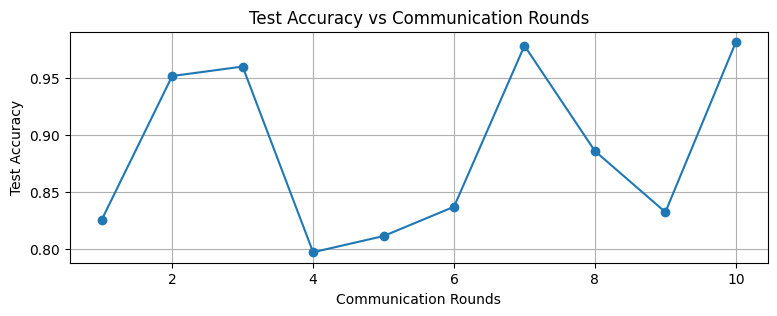

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()